# 蚁群算法
这个文章非常适合用来学习如何在图片上进行绘制

原文链接：https://www.kaggle.com/code/jamesmcguigan/ant-colony-optimization-algorithm/notebook

参考视频：https://www.bilibili.com/video/BV1vp4y1p78R/?spm_id_from=333.788&vd_source=4bccf0bae6366f8cf252ccd21d3e6844

顺带一提，如果出现读取文件报错，可以尝试在字符串前加一个r来使用原始字符串进行读取

In [3]:
import os
for dirname, _, filenames in os.walk('.\datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# 任何在这个工程文件夹的datasets子文件夹中的文件将被输出

#忽略警告
import warnings
warnings.filterwarnings('ignore')

.\datasets\united_states_map.png


In [7]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 读取图片
united_states_map = mpimg.imread(r".\datasets\united_states_map.png")

## 绘制城市，接受w和h参数作为绘制宽度和高度
#  isinstance方法对参数进行类型检验，如果path是一个字典类型，则将其值转为列表
#  之后再判断path的元素是否是一个包含（城市名，坐标）元组列表，如果是则去掉城市名
def show_cities(path, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]    
    plt.imshow(united_states_map)    #绘制图片
    for x0, y0 in path:
        plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point        
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

    
def show_path(path, starting_city=None, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    if isinstance(path, dict):      path = list(path.values())
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]
    
    starting_city = starting_city or path[0]
    x, y = list(zip(*path))
    #_, (x0, y0) = starting_city
    (x0, y0) = starting_city
    plt.imshow(united_states_map)
    # plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    
    # 不显示坐标轴
    plt.axis("off")
    
    fig = plt.gcf() #获取当前的绘制对象
    fig.set_size_inches([w, h]) #设置宽高
    
    
def polyfit_plot(x,y,deg, **kwargs):
    coefficients = np.polyfit(x,y,deg,**kwargs)
    poly  = np.poly1d(coefficients)
    new_x = np.linspace(x[0], x[-1])
    new_y = poly(new_x)
    plt.plot(x, y, "o", new_x, new_y)
    plt.xlim([x[0]-1, x[-1] + 1 ])
    
    terms = []
    for p, c in enumerate(reversed(coefficients)):
        term = str(round(c,1))
        if p == 1: term += 'x'
        if p >= 2: term += 'x^'+str(p)
        terms.append(term)        
    plt.title(" + ".join(reversed(terms)))    

In [8]:
## 返回两个城市之间的距离
def distance(xy1, xy2) -> float:
    if isinstance(xy1[0], str): xy1 = xy1[1]; xy2 = xy2[1];               # if xy1 == ("Name", (x,y))
    return math.sqrt( (xy1[0]-xy2[0])**2 + (xy1[1]-xy2[1])**2 )

## 获取路径的总长度，先进行预处理，然后返回其中0-1,1-2，...这n-1条边的总长度加上-1-0这条边的长度
def path_distance(path) -> int:
    if isinstance(path, dict):      path = list(path.values())            # if path == {"Name": (x,y)}
    if isinstance(path[0][0], str): path = [ item[1] for item in path ]   # if path == ("Name", (x,y))
    return int(sum(
        [ distance(path[i],  path[i+1]) for i in range(len(path)-1) ]
      + [ distance(path[-1], path[0]) ]                                   # include cost of return journey
    ))

[('Albany', (702.0, 193.6)), ('Atlanta', (585.6, 376.8)), ('Austin', (389.2, 448.4)), ('Baton Rouge', (489.6, 442.0)), ('Boise', (159.6, 182.8)), ('Boston', (738.4, 190.8)), ('Columbia', (632.4, 364.8)), ('Columbus', (590.8, 263.2)), ('Denver', (293.6, 274.0)), ('Des Moines', (447.6, 246.0)), ('Harrisburg', (670.8, 244.0)), ('Hartford', (719.6, 205.2)), ('Indianapolis', (548.0, 272.8)), ('Jackson', (501.6, 409.6)), ('Lansing', (563.6, 216.4)), ('Little Rock', (469.2, 367.2)), ('Madison', (500.8, 217.6)), ('Montgomery', (559.6, 404.8)), ('Nashville', (546.4, 336.8)), ('Oklahoma City', (392.8, 356.4)), ('Phoenix', (179.6, 371.2)), ('Providence', (735.2, 201.2)), ('Raleigh', (662.0, 328.8)), ('Richmond', (673.2, 293.6)), ('Sacramento', (68.4, 254.0)), ('Saint Paul', (451.6, 186.0)), ('Salem', (80.0, 139.2)), ('Salt Lake City', (204.0, 243.2)), ('Tallahassee', (594.8, 434.8)), ('Trenton', (698.8, 239.6))]
30


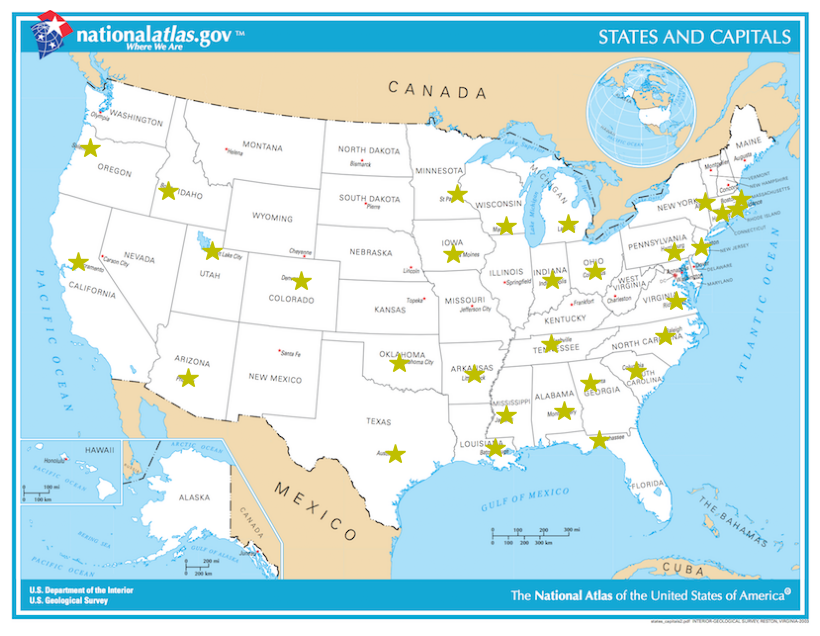

In [14]:
## 定义不同城市的首都和对应的坐标
cities = { 
    "Oklahoma City": (392.8, 356.4), 
    "Montgomery": (559.6, 404.8), 
    "Saint Paul": (451.6, 186.0), 
    "Trenton": (698.8, 239.6), 
    "Salt Lake City": (204.0, 243.2), 
    "Columbus": (590.8, 263.2), 
    "Austin": (389.2, 448.4), 
    "Phoenix": (179.6, 371.2), 
    "Hartford": (719.6, 205.2), 
    "Baton Rouge": (489.6, 442.0), 
    "Salem": (80.0, 139.2), 
    "Little Rock": (469.2, 367.2), 
    "Richmond": (673.2, 293.6), 
    "Jackson": (501.6, 409.6), 
    "Des Moines": (447.6, 246.0), 
    "Lansing": (563.6, 216.4), 
    "Denver": (293.6, 274.0), 
    "Boise": (159.6, 182.8), 
    "Raleigh": (662.0, 328.8), 
    "Atlanta": (585.6, 376.8), 
    "Madison": (500.8, 217.6), 
    "Indianapolis": (548.0, 272.8), 
    "Nashville": (546.4, 336.8), 
    "Columbia": (632.4, 364.8), 
    "Providence": (735.2, 201.2), 
    "Boston": (738.4, 190.8), 
    "Tallahassee": (594.8, 434.8), 
    "Sacramento": (68.4, 254.0), 
    "Albany": (702.0, 193.6), 
    "Harrisburg": (670.8, 244.0) 
}
cities = list(sorted(cities.items()))
# items将字典转元组，然后对键按字典序进行排序，然后转成元组列表
print(cities)
print(len(cities))
show_cities(cities)

7074

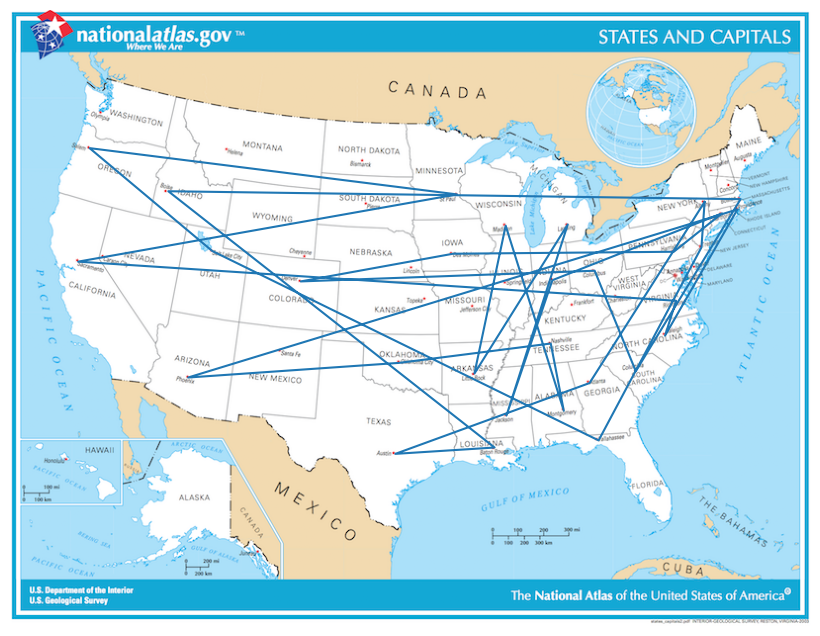

In [10]:
show_path(cities)
# 按字典序从头到尾进行绘制
path_distance(cities)

In [15]:
import time
from itertools import chain
from typing import Any, Callable, List, Tuple, Union

import numpy as np
import random


## 蚁群算法求解器的定义
class AntColonySolver:
    ## 初始化函数，具有多个可配置变量和一些参数
    def __init__(self,
                 cost_fn:                 Callable[[Any,Any], Union[float,int]],    
                 '''Callable[[Any, Any], Union[float, int]]：这是类型注解
                 指定了 cost_fn 参数的类型。在这里，它表示 cost_fn 参数应该是一个可调用的函数
                 并接受两个参数（任意类型），并且返回值可以是 float 或 int 类型。'''
                 
                 time=0,                  # 算法的运行时间
                 min_time=0,              # 算法的最小运行时间
                 timeout=0,               # 算法的最大运行时间
                 stop_factor=2,           # how many times to redouble effort after new new best path
                 min_round_trips=10,      # 最少循环次数
                 max_round_trips=0,       # 最大循环次数               
                 min_ants=0,              # 最少蚂蚁数
                 max_ants=0,              # 最大蚂蚁数
                 
                 ant_count=64,            # 蚂蚁数
                 ant_speed=1,             # 蚂蚁在每个循环中移动的步数

                 distance_power=1,        # 距离对信息素的影响的幂                 
                 pheromone_power=1.25,    # 信息素差异被感知的幂
                 decay_power=0,           # 信息素衰减速度的幂
                 reward_power=0,          # relative pheromone reward based on best_path_length/path_length 
                 best_path_smell=2,       # 发现新路径时信息素的增强倍数       
                 start_smell=0,           # 初始信息素数量，如果是0，则为10**self.distance_power

                 verbose=False,          # 是否输出详细信息

    ):
        assert callable(cost_fn)        
        self.cost_fn         = cost_fn
        self.time            = int(time)
        self.min_time        = int(min_time)
        self.timeout         = int(timeout)
        self.stop_factor     = float(stop_factor)
        self.min_round_trips = int(min_round_trips)
        self.max_round_trips = int(max_round_trips)
        self.min_ants        = int(min_ants)
        self.max_ants        = int(max_ants)
    
        self.ant_count       = int(ant_count)
        self.ant_speed       = int(ant_speed)
        
        self.distance_power  = float(distance_power)     
        self.pheromone_power = float(pheromone_power)
        self.decay_power     = float(decay_power)
        self.reward_power    = float(reward_power)
        self.best_path_smell = float(best_path_smell)
        self.start_smell     = float(start_smell or 10**self.distance_power)
        
        self.verbose         = int(verbose)
        self._initalized     = False
        
        # 防止最值赋错
        if self.min_round_trips and self.max_round_trips: self.min_round_trips = min(self.min_round_trips, self.max_round_trips)
        if self.min_ants and self.max_ants:               self.min_ants        = min(self.min_ants, self.max_ants)


    ## 初始化蚁群算法的求解器，接受一个参数problem_path，包含问题节点的列表，该方法没有返回值
    def solve_initialize(
            self,
            problem_path: List[Any],
    ) -> None:
        ### Cache of distances between nodes
        self.distances = {
            source: {
                dest: self.cost_fn(source, dest)
                for dest in problem_path
            }
            for source in problem_path
        }

        ### Cache of distance costs between nodes - division in a tight loop is expensive
        self.distance_cost = {
            source: {
                dest: 1 / (1 + self.distances[source][dest]) ** self.distance_power
                for dest in problem_path
            }
            for source in problem_path
        }

        ### This stores the pheromone trail that slowly builds up
        self.pheromones = {
            source: {
                # Encourage the ants to start exploring in all directions and furthest nodes
                dest: self.start_smell
                for dest in problem_path
            }
            for source in problem_path
        }
        
        ### Sanitise input parameters
        if self.ant_count <= 0:
            self.ant_count = len(problem_path)
        if self.ant_speed <= 0:
            self.ant_speed = np.median(list(chain(*[ d.values() for d in self.distances.values() ]))) // 5
        self.ant_speed = int(max(1,self.ant_speed))
        
        ### Heuristic Exports
        self.ants_used   = 0
        self.epochs_used = 0
        self.round_trips = 0
        self._initalized = True        


    def solve(self,
              problem_path: List[Any],
              restart=False,
    ) -> List[Tuple[int,int]]:
        if restart or not self._initalized:
            self.solve_initialize(problem_path)

        ### Here come the ants!
        ants = {
            "distance":    np.zeros((self.ant_count,)).astype('int32'),
            "path":        [ [ problem_path[0] ]   for n in range(self.ant_count) ],
            "remaining":   [ set(problem_path[1:]) for n in range(self.ant_count) ],
            "path_cost":   np.zeros((self.ant_count,)).astype('int32'),
            "round_trips": np.zeros((self.ant_count,)).astype('int32'),
        }

        best_path       = None
        best_path_cost  = np.inf
        best_epochs     = []
        epoch           = 0
        time_start      = time.perf_counter()
        while True:
            epoch += 1

            ### Vectorized walking of ants
            # Small optimization here, testing against `> self.ant_speed` rather than `> 0` 
            #       avoids computing ants_arriving in the main part of this tight loop
            ants_travelling = (ants['distance'] > self.ant_speed)
            ants['distance'][ ants_travelling ] -= self.ant_speed
            if all(ants_travelling):
                continue  # skip termination checks until the next ant arrives
            
            ### Vectorized checking of ants arriving
            ants_arriving       = np.invert(ants_travelling)
            ants_arriving_index = np.where(ants_arriving)[0]
            for i in ants_arriving_index:

                ### ant has arrived at next_node
                this_node = ants['path'][i][-1]
                next_node = self.next_node(ants, i)
                ants['distance'][i]  = self.distances[ this_node ][ next_node ]
                ants['remaining'][i] = ants['remaining'][i] - {this_node}
                ants['path_cost'][i] = ants['path_cost'][i] + ants['distance'][i]
                ants['path'][i].append( next_node )

                ### ant has returned home to the colony
                if not ants['remaining'][i] and ants['path'][i][0] == ants['path'][i][-1]:
                    self.ants_used  += 1
                    self.round_trips = max(self.round_trips, ants["round_trips"][i] + 1)

                    ### We have found a new best path - inform the Queen
                    was_best_path = False
                    if ants['path_cost'][i] < best_path_cost:
                        was_best_path  = True
                        best_path_cost = ants['path_cost'][i]
                        best_path      = ants['path'][i]
                        best_epochs   += [ epoch ]
                        if self.verbose:
                            print({
                                "path_cost":   int(ants['path_cost'][i]),
                                "ants_used":   self.ants_used,
                                "epoch":       epoch,
                                "round_trips": ants['round_trips'][i] + 1,
                                "clock":       int(time.perf_counter() - time_start),
                            })

                    ### leave pheromone trail
                    # doing this only after ants arrive home improves initial exploration
                    #  * self.round_trips has the effect of decaying old pheromone trails
                    # ** self.reward_power = -3 has the effect of encouraging ants to explore longer routes
                    #                           in combination with doubling pheromone for best_path
                    reward = 1
                    if self.reward_power: reward *= ((best_path_cost / ants['path_cost'][i]) ** self.reward_power)
                    if self.decay_power:  reward *= (self.round_trips ** self.decay_power)
                    for path_index in range( len(ants['path'][i]) - 1 ):
                        this_node = ants['path'][i][path_index]
                        next_node = ants['path'][i][path_index+1]
                        self.pheromones[this_node][next_node] += reward
                        self.pheromones[next_node][this_node] += reward
                        if was_best_path:
                            # Queen orders to double the number of ants following this new best path                            
                            self.pheromones[this_node][next_node] *= self.best_path_smell
                            self.pheromones[next_node][this_node] *= self.best_path_smell


                    ### reset ant
                    ants["distance"][i]     = 0
                    ants["path"][i]         = [ problem_path[0] ]
                    ants["remaining"][i]    = set(problem_path[1:])
                    ants["path_cost"][i]    = 0
                    ants["round_trips"][i] += 1


            ### Do we terminate?
            
            # Always wait for at least 1 solutions (note: 2+ solutions are not guaranteed)
            if not len(best_epochs): continue 
            
            # Timer takes priority over other constraints
            if self.time or self.min_time or self.timeout:
                clock = time.perf_counter() - time_start
                if self.time:
                    if clock > self.time: break
                    else:                 continue
                if self.min_time and clock < self.min_time: continue
                if self.timeout  and clock > self.timeout:  break
            
            # First epoch only has start smell - question: how many epochs are required for a reasonable result?
            if self.min_round_trips and self.round_trips <  self.min_round_trips: continue        
            if self.max_round_trips and self.round_trips >= self.max_round_trips: break

            # This factor is most closely tied to computational power                
            if self.min_ants and self.ants_used <  self.min_ants: continue        
            if self.max_ants and self.ants_used >= self.max_ants: break            
            
            # Lets keep redoubling our efforts until we can't find anything more
            if self.stop_factor and epoch > (best_epochs[-1] * self.stop_factor): break
                                
            # Nothing else is stopping us: Queen orders the ants to continue!      
            if True: continue
            
            
            
        ### We have (hopefully) found a near-optimal path, report back to the Queen
        self.epochs_used = epoch
        self.round_trips = np.max(ants["round_trips"])
        return best_path


    def next_node(self, ants, index):
        this_node   = ants['path'][index][-1]

        weights     = []
        weights_sum = 0
        if not ants['remaining'][index]: return ants['path'][index][0]  # return home
        for next_node in ants['remaining'][index]:
            if next_node == this_node: continue
            reward = (
                    self.pheromones[this_node][next_node] ** self.pheromone_power
                    * self.distance_cost[this_node][next_node]  # Prefer shorter paths
            )
            weights.append( (reward, next_node) )
            weights_sum   += reward

        # Pick a random path in proportion to the weight of the pheromone
        rand = random.random() * weights_sum
        for (weight, next_node) in weights:
            if rand > weight: rand -= weight
            else:             break
        return next_node
            
        
def AntColonyRunner(cities, verbose=False, plot=False, label={}, algorithm=AntColonySolver, **kwargs):
    solver     = algorithm(cost_fn=distance, verbose=verbose, **kwargs)
    start_time = time.perf_counter()
    result     = solver.solve(cities)
    stop_time  = time.perf_counter()
    if label: kwargs = { **label, **kwargs }
        
    for key in ['verbose', 'plot', 'animate', 'label', 'min_time', 'max_time']:
        if key in kwargs: del kwargs[key]
    print("N={:<3d} | {:5.0f} -> {:4.0f} | {:4.0f}s | ants: {:5d} | trips: {:4d} | "
          .format(len(cities), path_distance(cities), path_distance(result), (stop_time - start_time), solver.ants_used, solver.round_trips)
          + " ".join([ f"{k}={v}" for k,v in kwargs.items() ])
    )
    if plot:
        show_path(result)
    return result

{'path_cost': 4135, 'ants_used': 1, 'epoch': 3501, 'round_trips': 1, 'clock': 0}
{'path_cost': 3816, 'ants_used': 65, 'epoch': 8026, 'round_trips': 2, 'clock': 0}
{'path_cost': 3712, 'ants_used': 66, 'epoch': 8507, 'round_trips': 2, 'clock': 0}
{'path_cost': 3658, 'ants_used': 72, 'epoch': 9023, 'round_trips': 2, 'clock': 0}
{'path_cost': 3598, 'ants_used': 130, 'epoch': 11661, 'round_trips': 3, 'clock': 0}
{'path_cost': 3537, 'ants_used': 131, 'epoch': 11942, 'round_trips': 3, 'clock': 0}
{'path_cost': 3329, 'ants_used': 132, 'epoch': 12138, 'round_trips': 3, 'clock': 0}
{'path_cost': 3272, 'ants_used': 135, 'epoch': 12353, 'round_trips': 3, 'clock': 0}
{'path_cost': 3155, 'ants_used': 145, 'epoch': 12775, 'round_trips': 3, 'clock': 0}
{'path_cost': 2876, 'ants_used': 159, 'epoch': 13254, 'round_trips': 3, 'clock': 0}
{'path_cost': 2660, 'ants_used': 193, 'epoch': 14721, 'round_trips': 4, 'clock': 0}
{'path_cost': 2637, 'ants_used': 194, 'epoch': 14793, 'round_trips': 4, 'clock': 0}
{

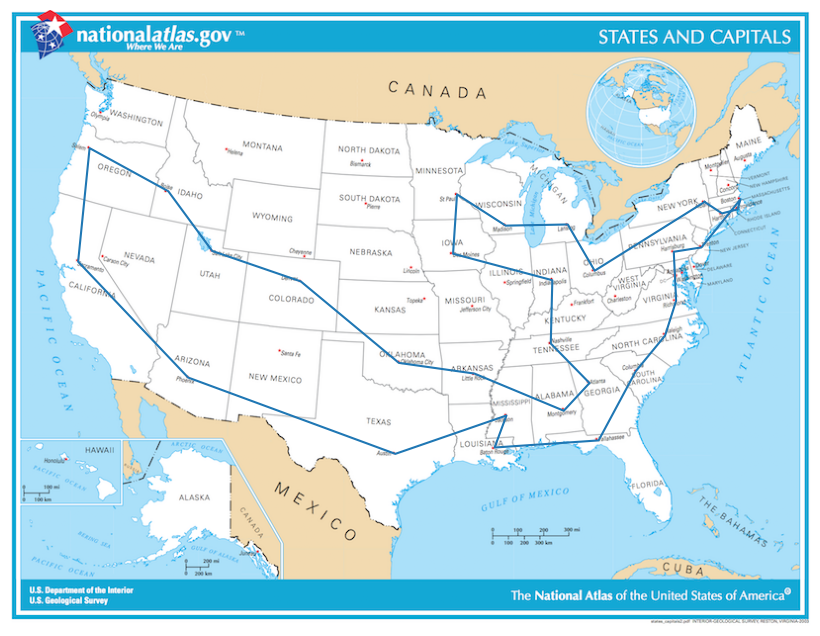

In [16]:
results = AntColonyRunner(cities, distance_power=1, verbose=True, plot=True)